<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Testing_Pytrodes_Funcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycorrelate
import pycorrelate as pyc

In [2]:
import scipy as sci
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def hilbert_data(pyramidal_ripfilt,fs):
    """ Hilbert & Smooth """
    hilbert_signal = sci.signal.hilbert(pyramidal_ripfilt )
    pyramidal_envelope = np.abs(hilbert_signal)
    pyramidal_inst_phase = np.angle(hilbert_signal)
    pyramidal_inst_frequency = (np.diff(hilbert_signal) /(2.0*np.pi) * fs)
    gauss_width_ms = 4
    sigma = gauss_width_ms/1000*fs
    filter_width_sigmas = 8
    pyramidal_smoothed  = sci.ndimage.gaussian_filter1d(pyramidal_envelope,
                                                        sigma, axis=0, mode='reflect',
                                                        truncate=filter_width_sigmas)

    integ_phase = np.unwrap(np.angle(hilbert_signal))/(2*np.pi)

    return {'env_smoothed':pyramidal_smoothed,
            'inst_frequency':pyramidal_inst_frequency,
            'inst_phase':pyramidal_inst_phase,
            'integ_phase':integ_phase,
            'hilbert_signal':hilbert_signal,}

def z_norm(x):
    mean = np.mean(x)
    std = np.std(x)
    return {'z_env':(x-mean)/std,
            'mean':mean,
            'std':std}

def get_rips(z_env,fs,integ_phase,time,min_gap_ms=.003):
    over_absolute_min_thresh = z_env>3

    start_bool = np.diff(over_absolute_min_thresh,prepend=0)==1
    stop_bool = np.diff(over_absolute_min_thresh,prepend=0)==-1

    start_inds = np.where(start_bool)[0]
    stop_inds = np.where(stop_bool)[0]

    'merge sort gaps'
    min_gap_ind = int(min_gap_ms*fs)
    gaps =  start_inds[1:] - stop_inds[:-1]
    bad_gaps = np.where(gaps<min_gap_ind)[0]
    start_inds[bad_gaps+1]=-1
    stop_inds[bad_gaps]=-1
    start_inds = [s for s in start_inds if s>=0]
    stop_inds = [s for s in stop_inds if s>=0]


    rip_metrics = pd.DataFrame({'start_inds':start_inds,'stop_inds':stop_inds})
    rip_metrics['duration_ms'] = (rip_metrics['stop_inds']-rip_metrics['start_inds'])/fs*1000
    rip_metrics['duration_osc'] = ( integ_phase[rip_metrics['stop_inds']] - integ_phase[rip_metrics['start_inds']] )

    rip_metrics['start_time'] = time[rip_metrics['start_inds']]
    rip_metrics['stop_time'] = time[rip_metrics['stop_inds']]

    rip_metrics['time_check'] = (rip_metrics['duration_ms'] >=15)
    rip_metrics['osc_check'] = (rip_metrics['duration_osc'] >=3)

    rip_metrics['peak_z'] = np.nan
    for i in rip_metrics.index:
        inds = np.arange(rip_metrics.loc[i,'start_inds'],rip_metrics.loc[i,'stop_inds'])
        rip_metrics.at[i,'peak_z'] = np.max( z_env[inds] )
    return rip_metrics

def filter_rips(rip_metrics,exlude_df):

    rip_metrics_unfiltered = rip_metrics.copy()
    excl_bools = []
    for ex in exlude_df.index:
        start_ex_t = exlude_df.iloc[ex,0]
        stop_ex_t = exlude_df.iloc[ex,1]
        starts_in_exl = np.logical_and(rip_metrics['start_time'].values>start_ex_t,
                                    rip_metrics['start_time'].values<stop_ex_t )

        stops_in_exl = np.logical_and(rip_metrics['stop_time'].values>start_ex_t,
                                    rip_metrics['stop_time'].values<stop_ex_t,)
        excl_bools.append(np.logical_or(starts_in_exl,stops_in_exl))

    any_exclude = np.sum(np.stack(excl_bools),axis=0)>0

    # rip_metrics= rip_metrics[np.logical_not(any_exclude)]
    rip_metrics = rip_metrics[rip_metrics['time_check']]
    return rip_metrics, rip_metrics_unfiltered

def get_rip_hist(peak_z,total_dur_sec):
    binned_counts,edges = np.histogram(peak_z,bins=np.round(np.arange(3,30,.01),2))
    binned_counts=np.cumsum(binned_counts[::-1])[::-1]
    binned_rate = binned_counts/total_dur_sec

    rip_hist={'binned_counts':binned_counts,'edges':edges,'binned_rate':binned_rate}
    return rip_hist

def analyze_session(sdata):
    sdata.update( hilbert_data(sdata['ripfilt'],sdata['fs']) )
    sdata.update(z_norm(sdata['env_smoothed']))
    rip_metrics = get_rips(sdata['z_env'],sdata['fs'],sdata['integ_phase'],sdata['time'])
    rip_metrics, _ = filter_rips(rip_metrics,sdata['excludes'])
    rip_hist = get_rip_hist(rip_metrics['peak_z'],sdata['total_dur'])

    sdata.update({'rip_metrics':rip_metrics,
                 'rip_hist':rip_hist})
    return sdata


In [4]:
os.chdir("C:\\Users\\dennis.tabuena\\Desktop\\New folder (2)\\to Dennis")

session_data_loc = [('./ZL04_45_timestamp_session01.csv','./ZL04_45_excludedtime_session01.csv','./ZL04_45_LFP_FIR01_17.csv'),
        ('./ZL04_45_timestamp_session02.csv','./ZL04_45_excludedtime_session02.csv','./ZL04_45_LFP_FIR02_17.csv'),
        ('./ZL04_45_timestamp_session03.csv','./ZL04_45_excludedtime_session03.csv','./ZL04_45_LFP_FIR03_17.csv'),
        ('./ZL04_45_timestamp_session04.csv','./ZL04_45_excludedtime_session04.csv','./ZL04_45_LFP_FIR04_17.csv'),
        ]

sessions = list()
for (i,sesh) in enumerate(session_data_loc):
    sdata = dict()
    df = pd.read_csv(sesh[0],usecols=[0],header=None)
    sdata['time']=df[0].values

    df = pd.read_csv(sesh[1],header=None)
    sdata['excludes']=df

    df = pd.read_csv(sesh[2],usecols=[0],header=None)
    sdata['ripfilt']=df[0].values

    sdata['fs']=5000

    total_dur = np.max(sdata['time'])-np.min(sdata['time'])
    exclusion_duration  = np.sum(np.diff( sdata['excludes'],axis=1))
    sdata['total_dur'] =total_dur -  exclusion_duration

    sessions.append(sdata)



In [5]:
animal ={'sessions':sessions}
for sdata in animal['sessions']:
    sdata = analyze_session(sdata)

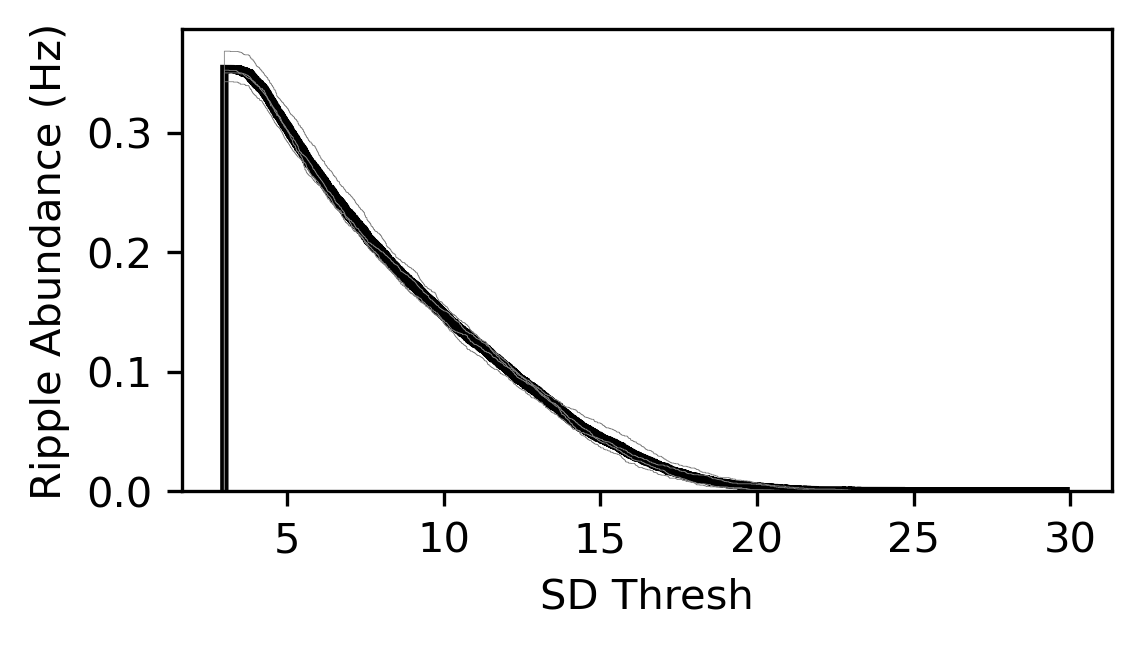

In [6]:
session_rates = [s['rip_hist']['binned_rate'] for s in animal['sessions']]

animal['mean_rates']=np.mean(np.stack(session_rates),axis=0)
animal['sd_rates']=np.std(np.stack(session_rates),axis=0)
animal['edges']=animal['sessions'][0]['rip_hist']['edges']

fig,ax=plt.subplots(1,1,dpi=300,figsize=(4,2))
ax.stairs(animal['mean_rates'],animal['edges'],linewidth=2,color='k')
ax.set_ylabel('Ripple Abundance (Hz)')
ax.set_xlabel('SD Thresh')


for s in animal['sessions']:
    ax.stairs(s['rip_hist']['binned_rate'],animal['edges'],linewidth=.2,color='gray')

In [7]:
rough_rates = list()
threshes = np.arange(3,11)
for thr in threshes:
    thr_ind = np.where(animal['edges'].flatten()==thr)[0][0]
    thr_rate = animal['mean_rates'][thr_ind]
    rough_rates.append(thr_rate)
    print(f'{thr}sd, rate:{thr_rate:.3f}')



3sd, rate:0.353
4sd, rate:0.342
5sd, rate:0.304
6sd, rate:0.265
7sd, rate:0.230
8sd, rate:0.200
9sd, rate:0.173
10sd, rate:0.148


In [ ]:

maxlag=sdata['fs']*0.600
cross_corr = pyc.ucorrelate(sdata['z_env'], sdata['z_env'], maxlag=maxlag)


In [10]:

cross_corr_d = np.concatenate([cross_corr[::-1],cross_corr])
max_lag_d = np.concatenate( [np.arange(-maxlag,0),np.arange(maxlag)])/sdata['fs']*1000
cross_corr_d = cross_corr_d/np.max(cross_corr)

Text(0, 0.5, 'CorrCoeff')

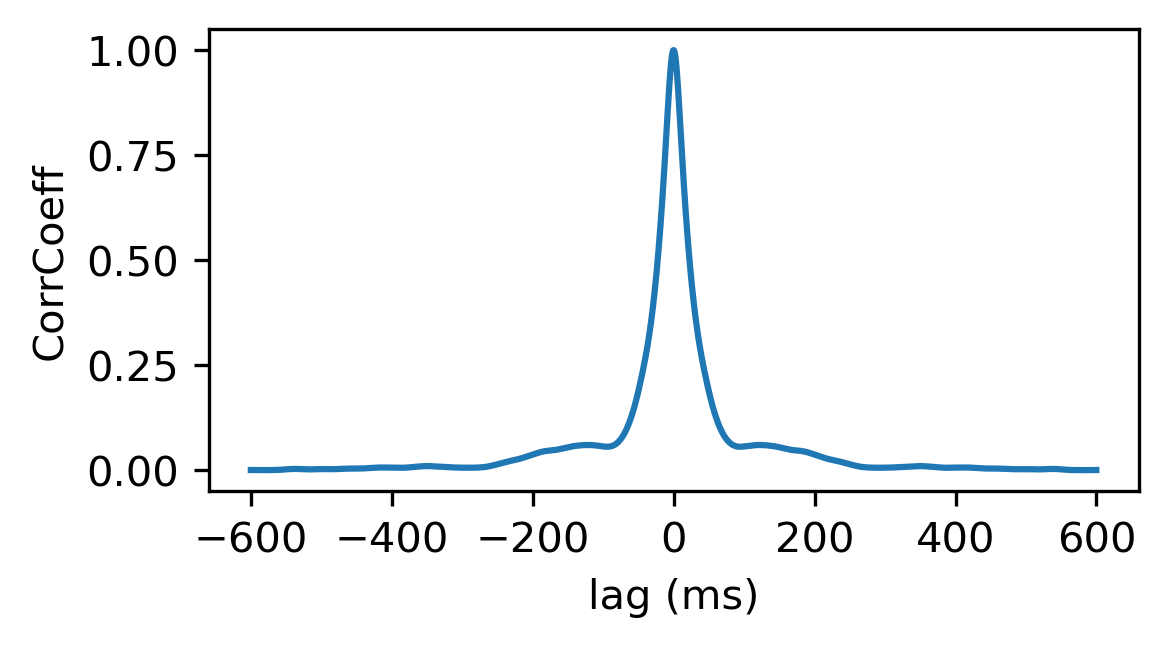

In [11]:
fig,ax=plt.subplots(1,figsize=(4,2),dpi=300)
ax.plot(max_lag_d,cross_corr_d)
ax.set_xlabel('lag (ms)')
ax.set_ylabel('CorrCoeff')

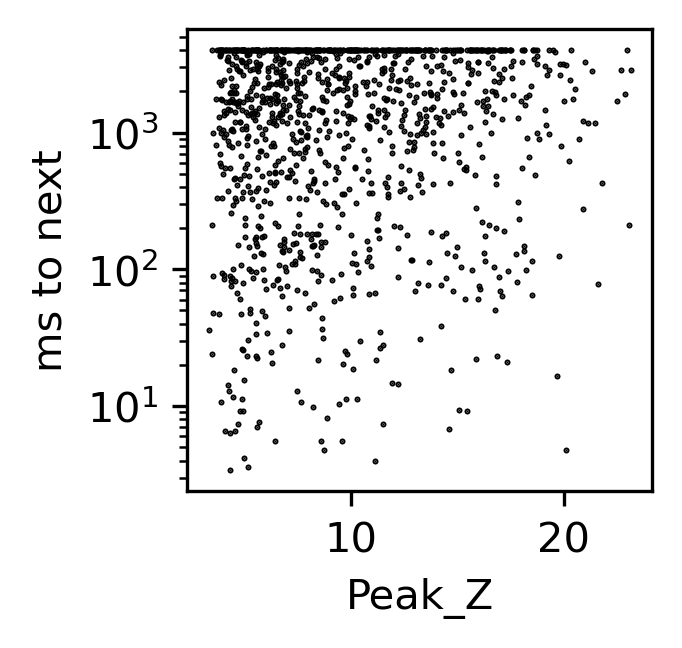

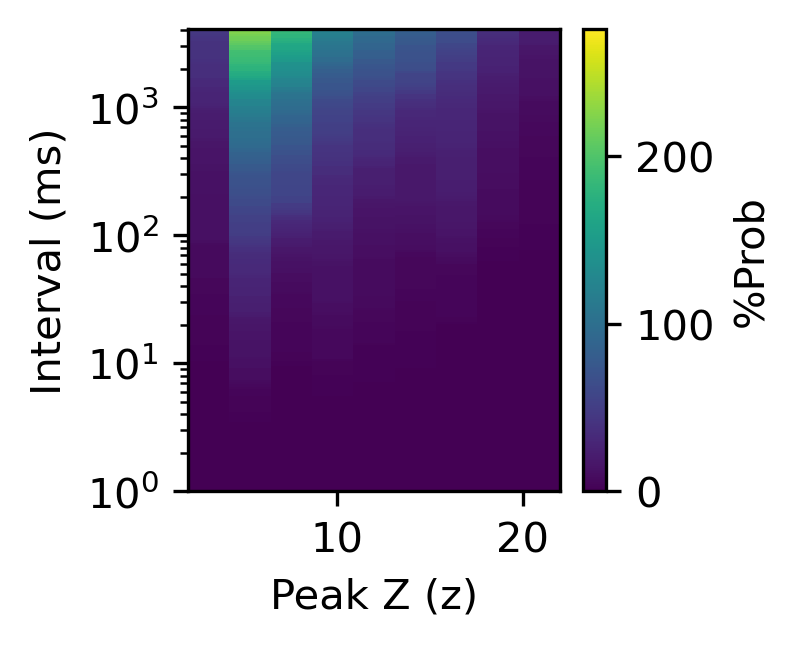

In [155]:
rip_metrics = sdata['rip_metrics']

interval = rip_metrics['start_time'].values[1:] - rip_metrics['stop_time'].values[:-1]
interval = interval*1000

interval[interval>4000]=4000

peak_z = rip_metrics['peak_z'].values[:-1]

fig,ax = plt.subplots(1,1,figsize=(2,2),dpi=300)
ax.scatter(peak_z,interval ,s=.2,color='k')
ax.set_xlabel('Peak_Z')
ax.set_ylabel('ms to next')
ax.set_yscale('log')


counts, peak_edges, time_edges = np.histogram2d(peak_z,interval,
                                                bins=[np.linspace(2,22,num=10),
                                                      np.logspace(0,12,num=200,base=2)])
counts = np.cumsum(counts,1)
# counts = (counts.T/np.max(counts,axis=1)).T
fig,ax = plt.subplots(1,1,figsize=(2,2),dpi=300)
cbh = ax.pcolormesh(peak_edges, time_edges, counts.T )
ax.set_yscale('log')
ax.set_ylabel('Interval (ms)')
ax.set_xlabel('Peak Z (z)')
plt.colorbar(cbh,label='%Prob')

In [71]:
log2_time_edges

array([ 1.76553468,  2.27554716,  2.78555964,  3.29557212,  3.8055846 ,
        4.31559708,  4.82560956,  5.33562204,  5.84563452,  6.355647  ,
        6.86565948,  7.37567196,  7.88568444,  8.39569692,  8.9057094 ,
        9.41572188,  9.92573436, 10.43574684, 10.94575932, 11.4557718 ,
       11.96578428])

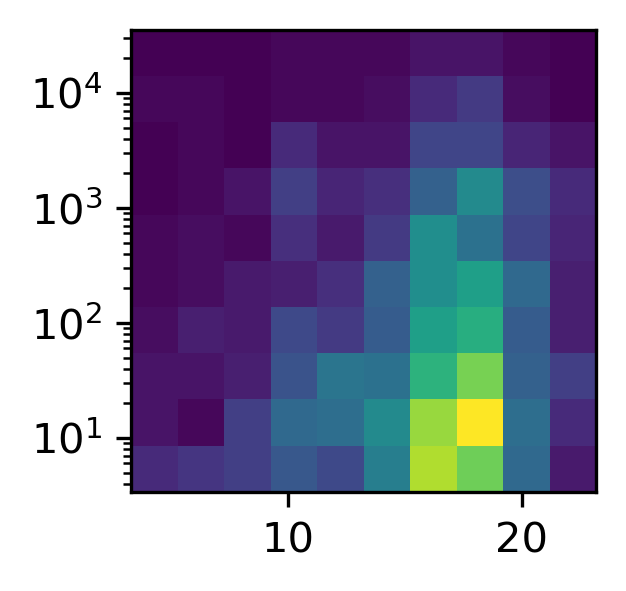

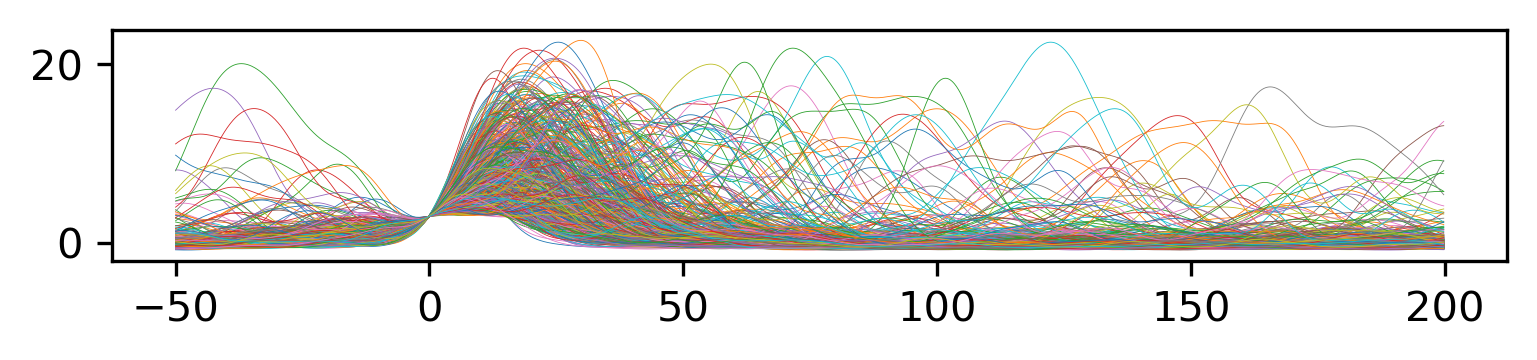

In [122]:
fig,ax=plt.subplots(1,figsize=(6,1),dpi=300)
_ = ax.plot(rip_window_ms,env_mat[:500,:].T,linewidth=.2)

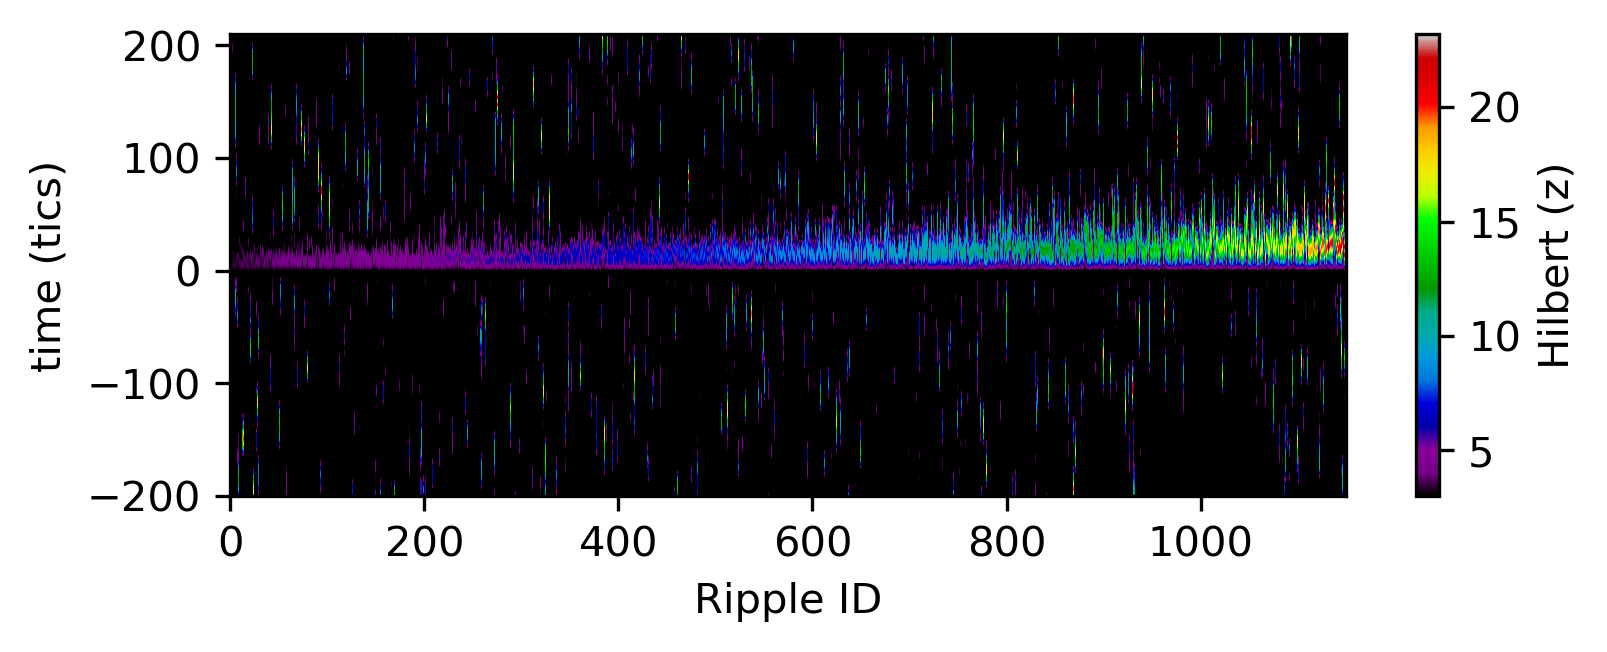

In [163]:
rip_window_ss_ms = np.array([-200,210])
rip_window_ss_ind = (rip_window_ss_ms/1000*sdata['fs']).astype(int)
rip_window_inds = np.arange(rip_window_ss_ind[0],rip_window_ss_ind[1])
rip_window_ms = rip_window_inds/sdata['fs']*1000
starts_vec = np.expand_dims(sdata['rip_metrics']['start_inds'].values,1)
starts_mat = np.repeat(starts_vec, len(rip_window_inds),axis=1)

rip_mat_inds = starts_mat+rip_window_inds
env_mat = sdata['z_env'][rip_mat_inds]
fig,ax = plt.subplots(1,1,figsize=(6,2),dpi=300)

ord = np.arange(env_mat.shape[0] )
ord = np.argsort(sdata['rip_metrics']['peak_z'].values)
cbh = ax.pcolorfast(range(env_mat.shape[0]),rip_window_ms,env_mat[ord,:].T,cmap='nipy_spectral',vmin=3) #
ax.set_ylabel('time (tics)')
ax.set_xlabel('Ripple ID')
plt.colorbar(cbh,label='Hilbert (z)')


In [200]:
iri = rip_metrics['start_time'].values[1:] - rip_metrics['start_time'].values[:-1]
post_iri = iri[:-1]
pre_iri = iri[1:]
print(len(rip_metrics),len(iri),len(post_iri),len(pre_iri))

[9.65419956 0.41539998 6.6259997  ... 2.57799988 7.48619966 3.50099984]
1151 1150 1149 1149


SignificanceResult(statistic=0.06778987423517205, pvalue=0.021561248587427095)


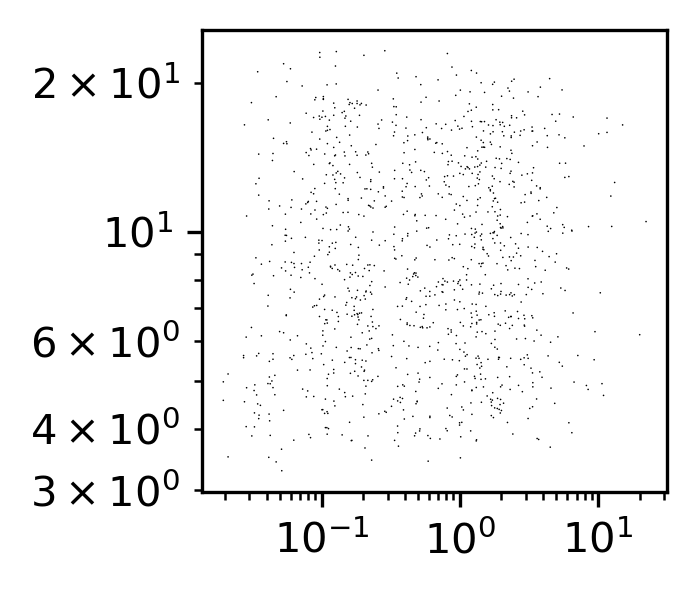

In [228]:
min_iri = np.minimum(post_iri,pre_iri)

peak_z_trim = rip_metrics['peak_z'].values[1:-1]

fig,ax=plt.subplots(1,figsize=(2,2),dpi=300)
ax.scatter(min_iri,peak_z_trim,s=.6,color='k',marker=".",edgecolors='none')
spear_corr = sci.stats.spearmanr(min_iri, peak_z_trim)
ax.set_xscale('log')
ax.set_yscale('log')
print(spear_corr)

In [216]:
np.argsort(peak_z_trim)

array([763, 631, 681, ..., 777, 733, 854], dtype=int64)

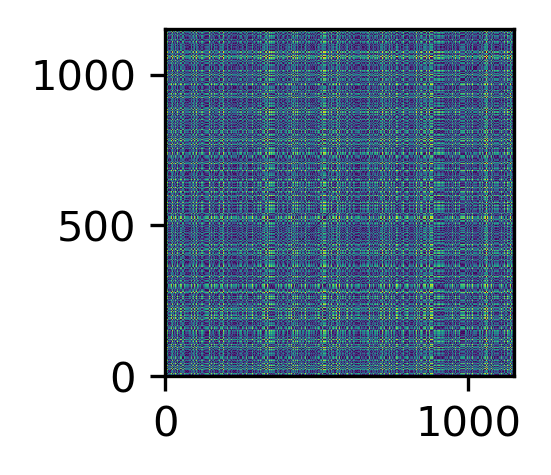

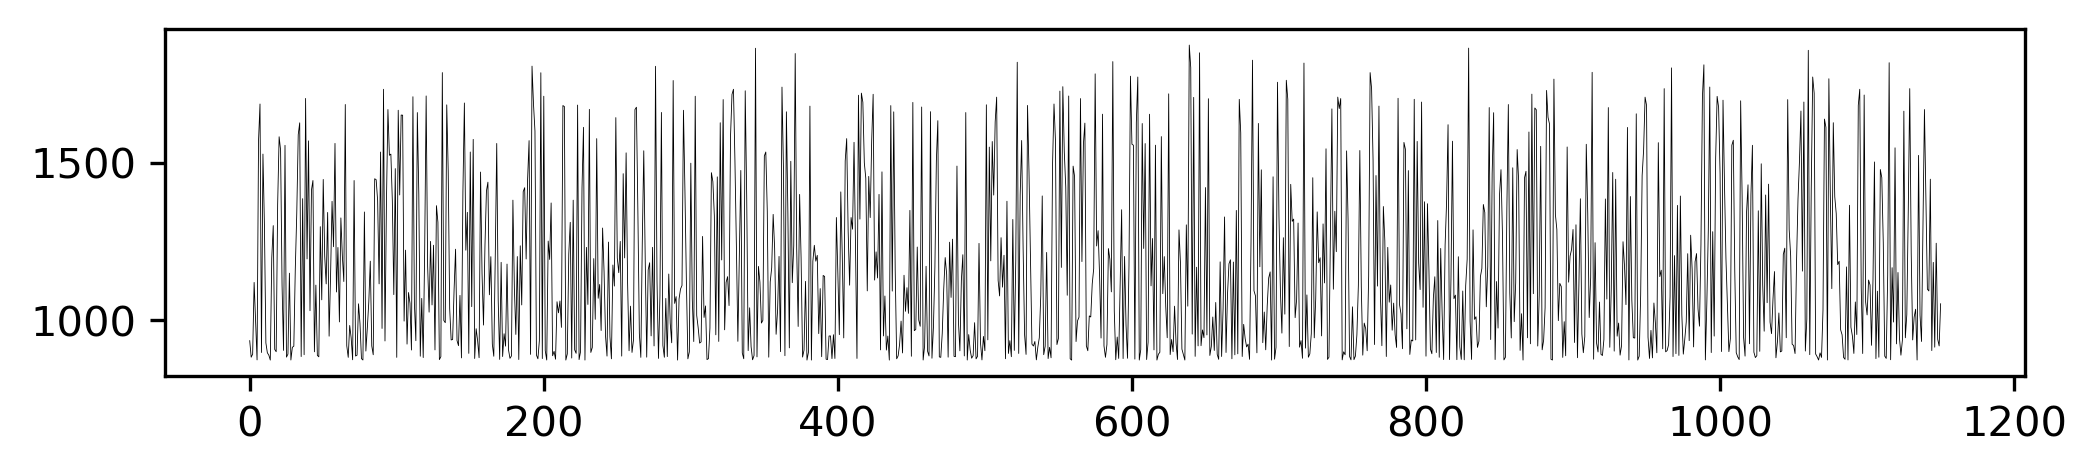

In [193]:
sorted_times = rip_metrics['start_time'].values[ord]
sorted_peaks = rip_metrics['peak_z'].values[ord]

deltaT=np.ones([len(sorted_times),len(sorted_times)])
deltaT*=sorted_times
deltaT-=deltaT.T
deltaT = abs(deltaT)
fig,ax=plt.subplots(1,figsize=(1.5,1.5),dpi=300)
plt.pcolormesh(deltaT)
fig,ax=plt.subplots(1,figsize=(8,1.5),dpi=300)
ax.plot(np.mean(deltaT,axis=1),linewidth=.2,color='k')

In [21]:
""" DIm Reduction on Env/RippTrace"""

' DIm Reduction on Env/RippTrace'

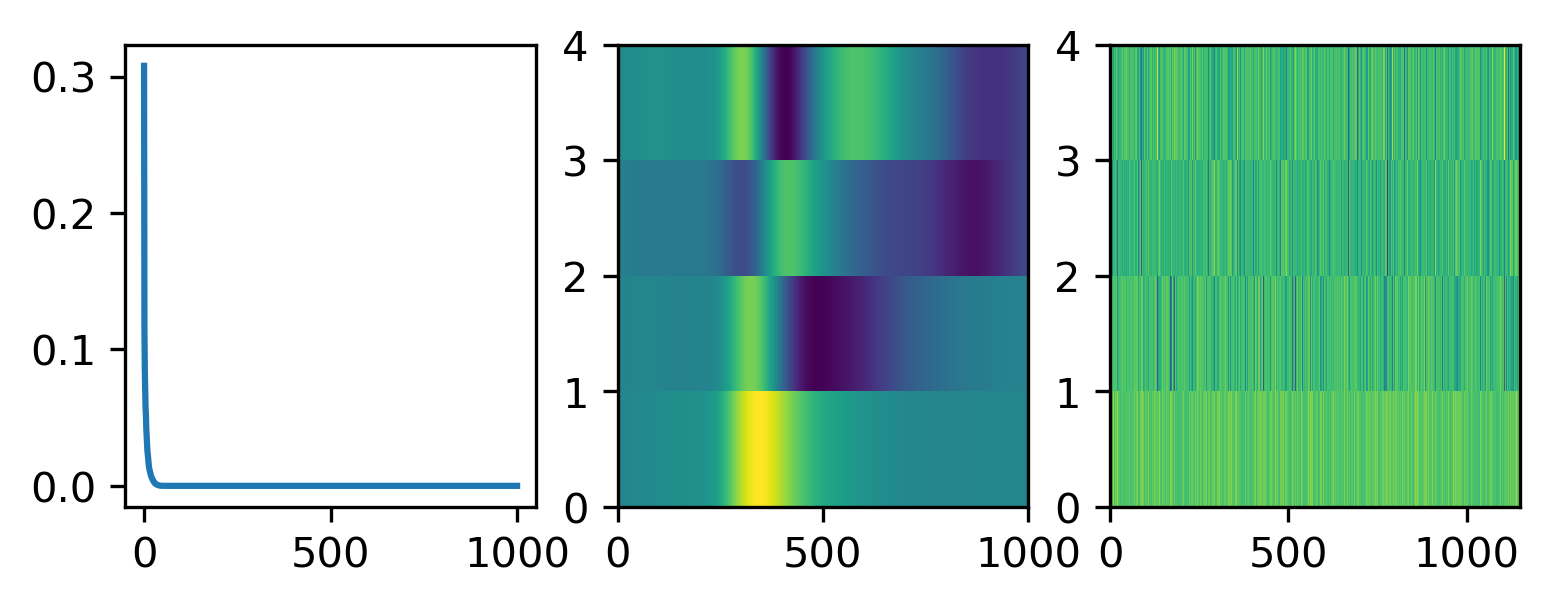

In [ ]:
k=4
(u,s,vh) = np.linalg.svd(env_mat,full_matrices=True)

fig,ax = plt.subplots(1,3,figsize=(6,2),dpi=300)
ax[0].plot(np.arange(len(s)),s/np.sum(s))

ax[1].pcolorfast(vh[:k,:])
ax[2].pcolorfast(u[:,:k].T)

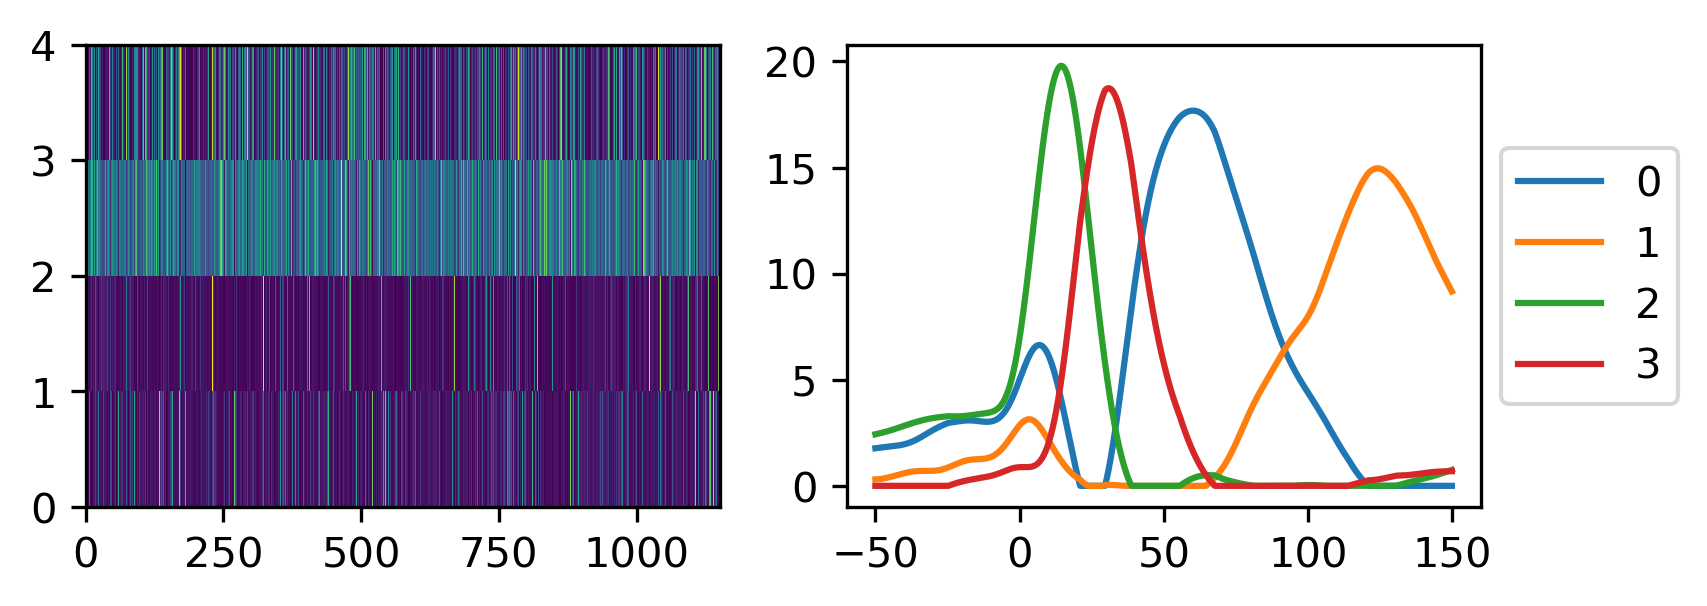

In [ ]:
import sklearn as skl
import sklearn.decomposition
k=4
NMF_model = skl.decomposition.NMF(n_components=k, init='random', random_state=0,max_iter=2000)
W = NMF_model.fit_transform(env_mat-np.min(env_mat))
H = NMF_model.components_
s = np.max(W,axis=0)
Hn = (H.T*s).T
Wn = W/s
fig,ax = plt.subplots(1,2,figsize=(6,2),dpi=300)
cbh=ax[0].pcolorfast(Wn.T)
# plt.colorbar(cbh)
ax[1].plot(rip_window_ms,Hn.T)
ax[1].legend(range(k),loc='center left', bbox_to_anchor=(1, 0.5))



In [ ]:
NMF_model.reconstruction_err_

962.1458582833675

In [ ]:
SPCA_model = skl.decomposition.SparsePCA(n_components=k, random_state=0,max_iter=200)
SPCA_model.fit_transform(env_mat)

array([[ -5.34345411, -12.52145027,  -7.85566135,  20.18997494,
         -8.12038349,  -1.48789025],
       [-37.39238919,  -4.93939674,  -3.69014446,  25.21647344,
        -11.67236662, -12.49642333],
       [-31.76780464, -19.59344313,  -5.69597629, -17.94256905,
         -5.63024318,   2.70956929],
       ...,
       [  3.25445884,   1.64480812,  -5.25081937,   4.22342798,
        -13.1731168 ,   1.09346377],
       [ -5.66108966, -15.08800693,  -2.0605098 ,   1.71729594,
         -6.84457341,  -8.44658219],
       [-31.66934852,  -6.55135592,   6.45724208, -25.89737349,
         -9.22398129,   7.90658645]])

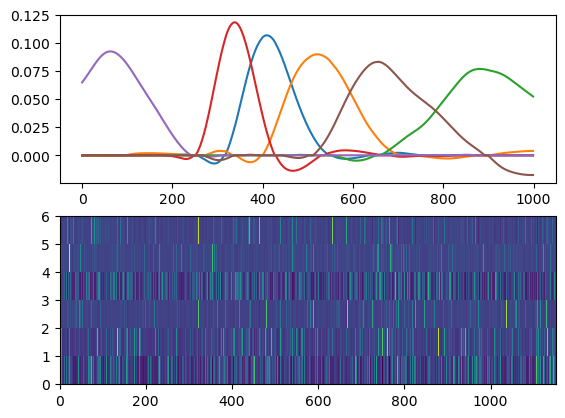

In [ ]:
m = SPCA_model.components_
X_transformed = SPCA_model.transform(env_mat)
fig,ax=plt.subplots(2)
ax[0].plot(m.T)
ax[1].pcolorfast(X_transformed.T)

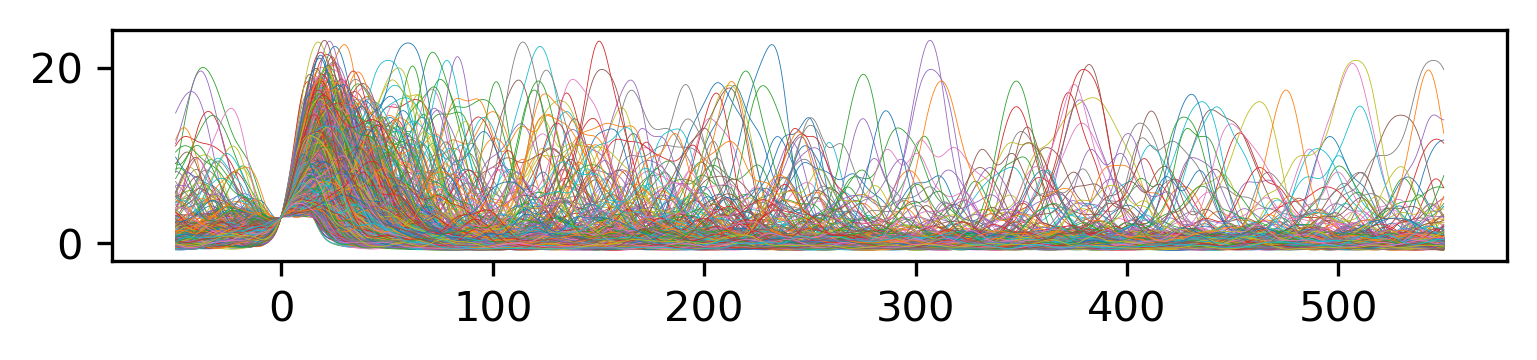

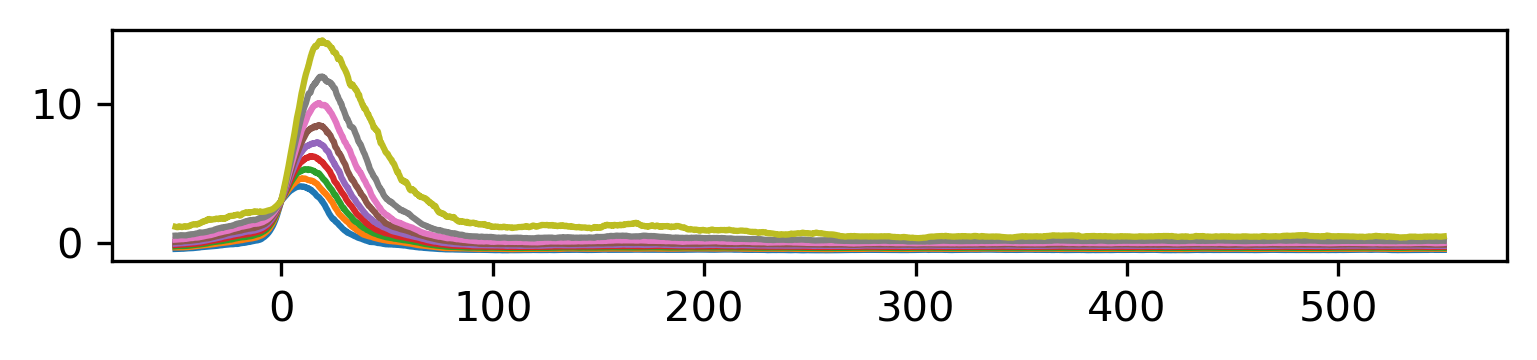

In [ ]:
fig,ax=plt.subplots(1,figsize=(6,1),dpi=300)
prcmap = np.percentile(env_mat, [np.arange(10,100,10)], axis=0)[0]
_ = ax.plot(rip_window_ms,prcmap.T)

In [166]:
zl_dir = "C:\\Users\\dennis.tabuena\\Desktop\\ZL04_46_ch17_ref2"

mat_data = sci.io.loadmat(os.path.join(zl_dir, 'ZL04_46_LFP_raw01_17.mat'))
raw_pyramidal_lfp = mat_data['Raw_LFP'][0][0][-1][0][0][4].flatten()


In [ ]:
mat_data = sci.io.loadmat(os.path.join(zl_dir, 'ZL04_46_LFP_raw01_2.mat'))
raw_corpcol_lfp = mat_data['Raw_LFP'][0][0][-1][0][0][4].flatten()

In [165]:
raw_pyramidal_lfp=raw_pyramidal_lfp-raw_corpcol_lfp

NameError: name 'raw_corpcol_lfp' is not defined

In [167]:
"""Down Sampling"""
raw_fs = 30000
desired_fs = 5000
downsample_factor = int(raw_fs/desired_fs)


pyramidal_downsampled = sci.signal.decimate(raw_pyramidal_lfp,downsample_factor)
fs = raw_fs/downsample_factor
print(f'fs: {fs}')
time_trace = np.arange(len(pyramidal_downsampled))/fs



fs: 5000.0


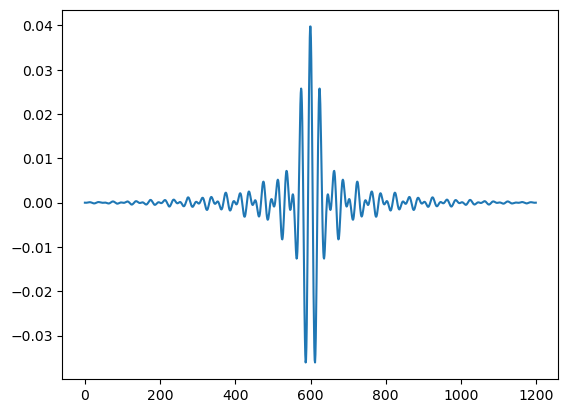

In [169]:
"""Ripple Filtering"""
h_filt = sci.signal.firwin(1200, [150,250], width=10, window='hamming', pass_zero='bandpass', scale=True, fs=fs)
plt.plot(h_filt)
pyramidal_ripfilt = sci.signal.filtfilt(h_filt,1,pyramidal_downsampled,axis=0)

In [172]:
sdata

{'time': array([  34.163     ,   34.1632    ,   34.1634    , ..., 3711.19863333,
        3711.19883333, 3711.19903333]),
 'excludes':              0            1
 0    34.163167    64.118955
 1    83.578555   114.300732
 2   195.971074   227.226391
 3   432.551829   465.473208
 4   755.567863   808.282053
 5   841.536644   872.525391
 6  1600.227800  1636.248053
 7  2113.341468  2151.161068
 8  2175.252319  2210.372899,
 'ripfilt': array([ 5.74868716e-07, -8.97202517e-01, -1.72644304e+00, ...,
        -2.25772665e+00, -1.16251602e+00, -1.36873506e-08]),
 'fs': 5000,
 'total_dur': 3359.5180033782535,
 'env_smoothed': array([3.14252381, 3.14698451, 3.15589807, ..., 3.66854589, 3.67467265,
        3.67774247]),
 'inst_frequency': array([-713.97153508+591.89885828j, -659.888644   +77.10906708j,
        -557.01664608-175.12095016j, ...,  767.77288177-229.31855857j,
         871.5409214  +15.3143891j ,  925.10084641+696.42426393j]),
 'inst_phase': array([ 1.57079409,  2.30146362,  2.57508585

In [170]:
""" Hilbert & Smooth """
hilbert_signal = sci.signal.hilbert(pyramidal_ripfilt )
pyramidal_envelope = np.abs(hilbert_signal)
pyramidal_inst_phase = np.angle(hilbert_signal)
pyramidal_inst_frequency = (np.diff(hilbert_signal) /(2.0*np.pi) * fs)


gauss_width_ms = 4
sigma = gauss_width_ms/1000*fs
filter_width_sigmas = 8
pyramidal_smoothed  = sci.ndimage.gaussian_filter1d(pyramidal_envelope, sigma, axis=0, mode='reflect', truncate=filter_width_sigmas)

In [171]:
""" Z-score """
def z_with_params(x,mean,std):
    return (x-mean)/std

full_trace_std = np.std(pyramidal_smoothed)
full_trace_mean = np.mean(pyramidal_smoothed)
pyramidal_ripp_z = z_with_params(pyramidal_smoothed,full_trace_mean,full_trace_std)

In [ ]:
time_trace[random_start]

712.6046

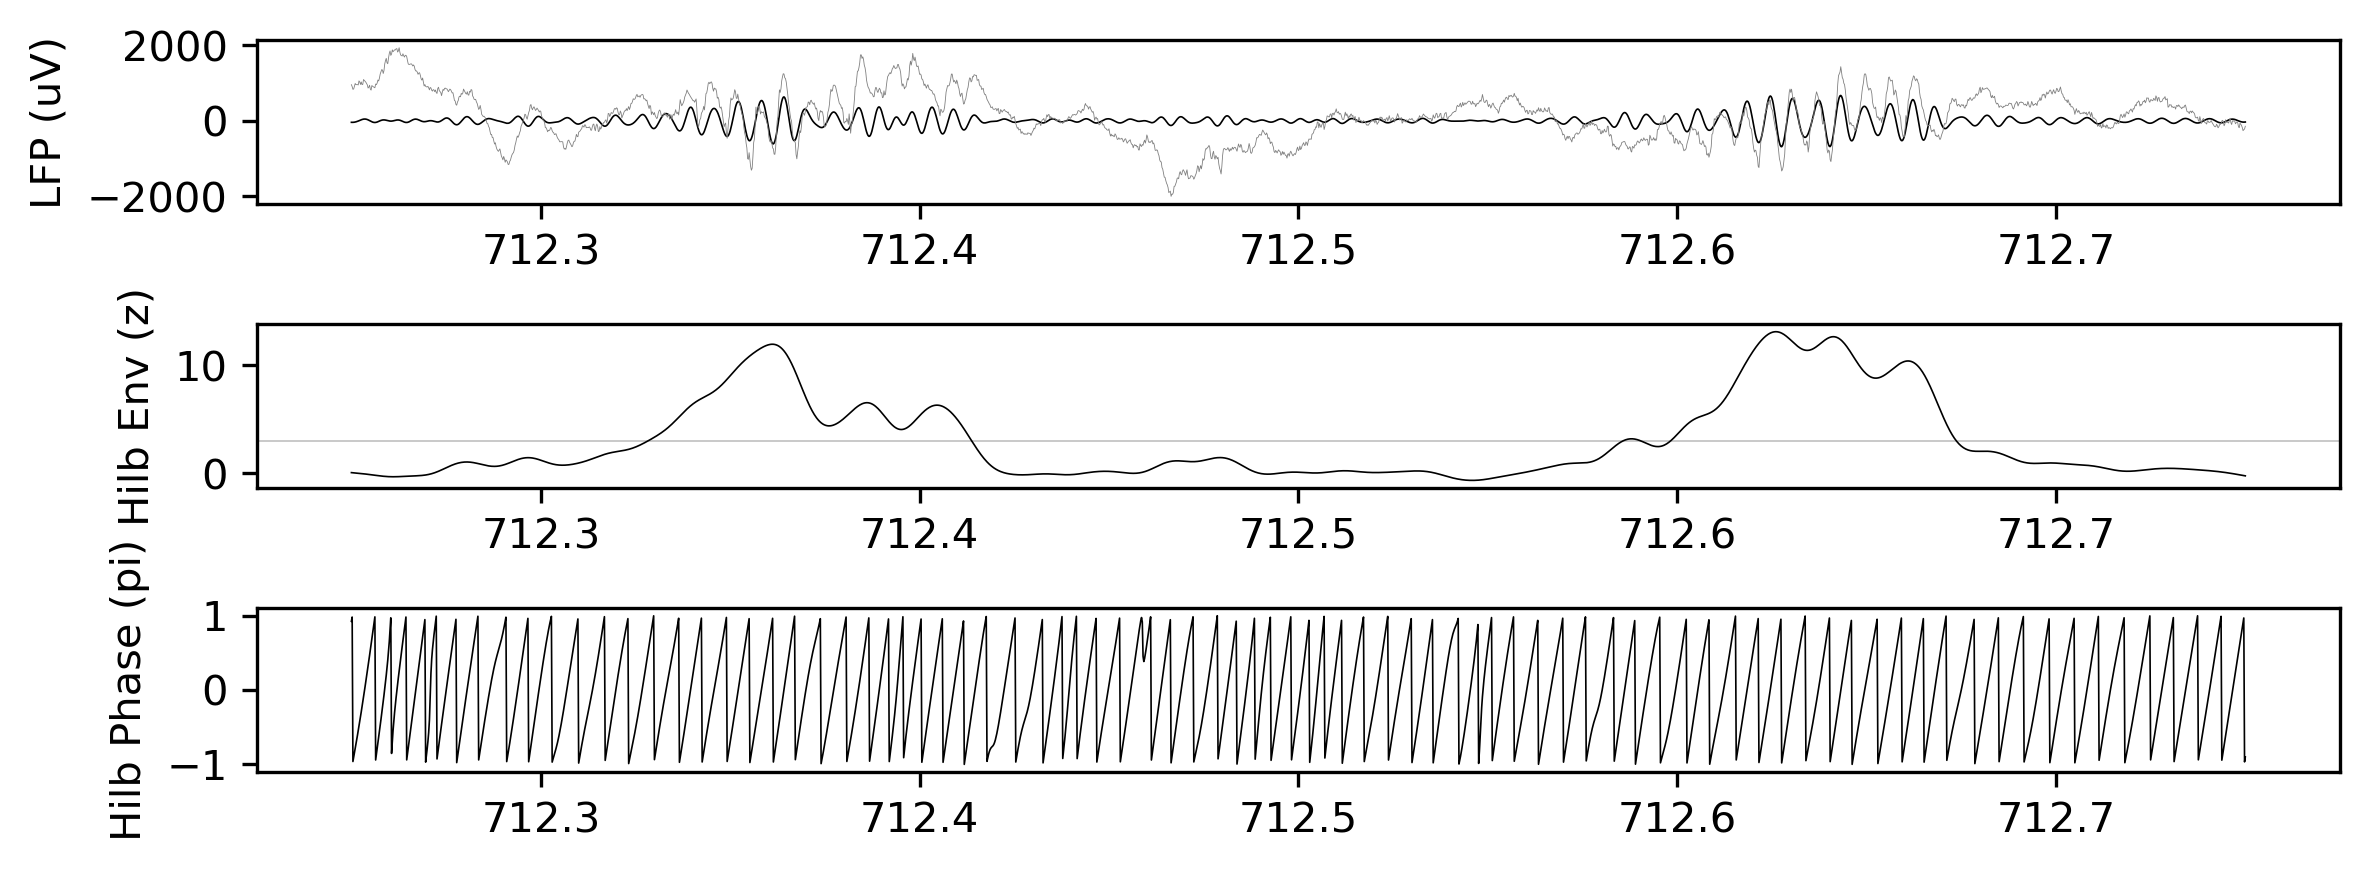

In [ ]:
""" Find Ripps """
over_absolute_min_thresh = pyramidal_ripp_z>3

start_bool = np.diff(over_absolute_min_thresh,prepend=0)==1
stop_bool = np.diff(over_absolute_min_thresh,prepend=0)==-1

starts = np.where(start_bool)[0]
stops = np.where(stop_bool)[0]

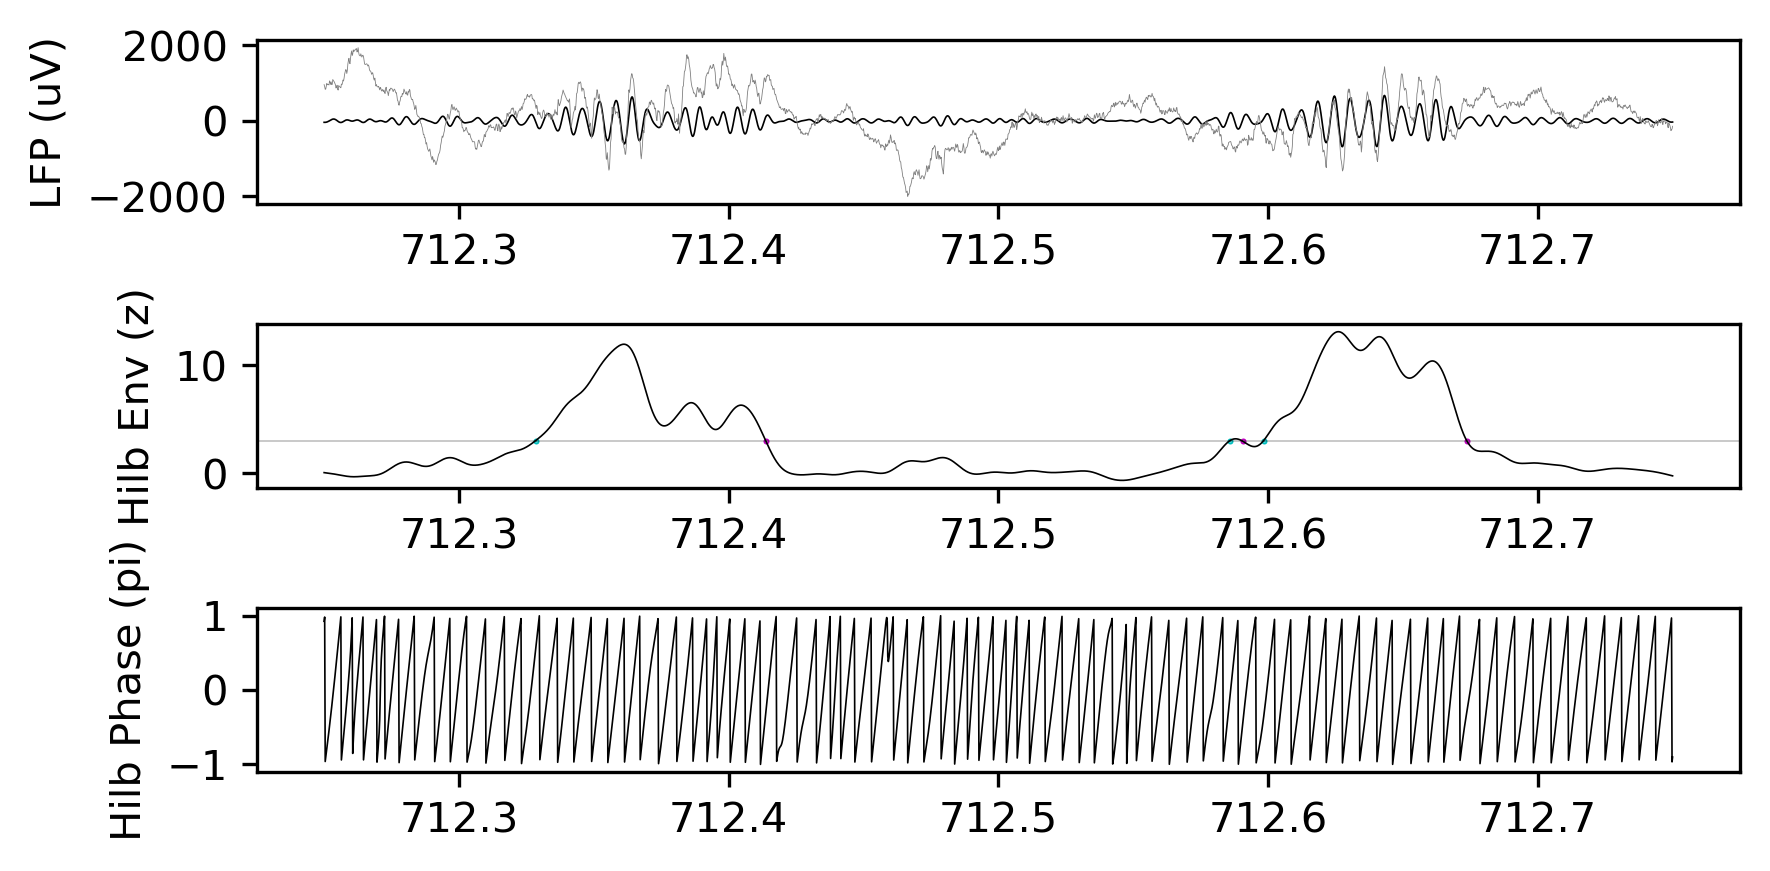

In [ ]:



def plot_section(t0,t1):
    indx_bool =  np.logical_and(time_trace>=t0, time_trace<=t1)
    fig, ax=plt.subplots(3,1,figsize=(6,3),dpi=300)
    ax[0].plot(time_trace[indx_bool],pyramidal_ripfilt[indx_bool],color='k',linewidth=.4)
    ax[0].plot(time_trace[indx_bool],pyramidal_downsampled[indx_bool],color='gray',linewidth=.2)
    ax[0].set_ylabel('LFP (uV)')
    ax[1].plot(time_trace[indx_bool],pyramidal_ripp_z[indx_bool],color='k',linewidth=.4)
    ax[1].set_ylabel('Hilb Env (z)')
    ax[1].axhline(3,linewidth=.1,color='k')
    ax[2].plot(time_trace[indx_bool],np.angle(hilbert_signal)[indx_bool]/np.pi,color='k',linewidth=.4)
    ax[2].set_ylabel('Hilb Phase (pi)')

    # ax2=ax[2].twinx()
    # ax2.plot(time_trace[indx_bool],np.unwrap(np.angle(hilbert_signal)[indx_bool])/(2*np.pi),color='gray',linewidth=.2)


    rel_starts_t = time_trace[np.logical_and(indx_bool,start_bool)]
    rel_stops_t = time_trace[np.logical_and(indx_bool,stop_bool)]
    ax[1].scatter(rel_starts_t,np.ones_like(rel_starts_t)*3,s=.2,color='c')
    ax[1].scatter(rel_stops_t,np.ones_like(rel_stops_t)*3,s=.2,color='m')
    plt.tight_layout()
    return fig,ax

t0 = 712.25
t1 = t0+.5
fig,ax = plot_section(t0,t1)

In [ ]:
start_inds = np.where(start_bool)[0]
stop_inds = np.where(stop_bool)[0]
import pandas as pd
rip_stats = pd.DataFrame({'start_inds':start_inds,'stop_inds':stop_inds})
rip_stats['duration_ms'] = (rip_stats['stop_inds']-rip_stats['start_inds'])/fs*1000
rip_stats['duration_osc'] = ( integ_phase[rip_stats['stop_inds']] - integ_phase[rip_stats['start_inds']] )

integ_phase = np.unwrap(np.angle(hilbert_signal))/(2*np.pi)
rip_stats['peak_z'] = np.nan
for i in rip_stats.index:
    inds = np.arange(rip_stats.loc[i,'start_inds'],rip_stats.loc[i,'stop_inds'])
    z_trace = pyramidal_ripp_z[inds]
    rip_stats.at[i,'peak_z'] = np.max(z_trace)

rip_stats['time_check'] = (rip_stats['duration_ms'] >=15)
rip_stats['osc_check'] = (rip_stats['duration_osc'] >=3)

display(rip_stats.head(8))
print(pd.crosstab(rip_stats['time_check'], rip_stats['osc_check']))


,start_inds,stop_inds,duration_ms,duration_osc,peak_z,time_check,osc_check
0,1460,1502,8.4,1.485238,3.618186,False,False
1,1559,1755,39.2,6.349131,11.069146,True,True
2,5112,5212,20.0,3.815815,7.360084,True,True
3,17971,18043,14.4,2.389337,4.512625,False,False
4,21125,21213,17.6,3.124541,5.491970,True,True
5,33362,33456,18.8,3.352179,5.780865,True,True
6,43156,43269,22.6,4.024714,8.699331,True,True
7,46571,46707,27.2,4.558868,5.640546,True,True


osc_check   False  True 
time_check              
False         962      4
True           95   1133


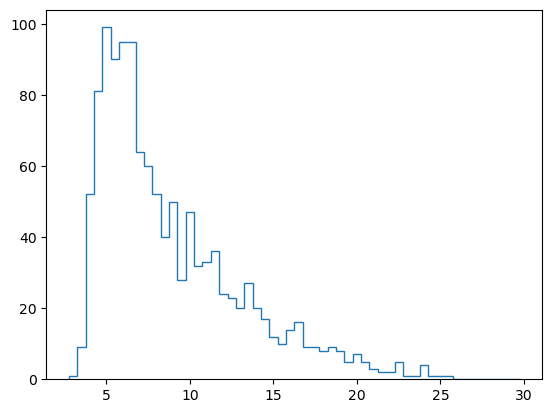

In [ ]:

"""USE 15ms"""
rip_stats = rip_stats[rip_stats['time_check']]
binned_counts,edges = np.histogram(rip_stats['peak_z'],bins=np.arange(2.75,30,.5) )
bin_thresh = edges[:-1]
# print(bin_thresh,binned_counts)
plt.stairs(binned_counts,edges)


In [ ]:
print(pyramidal_ripp_z.shape)

(18192760,)


In [ ]:
""" Find Ripps """
over_absolute_min_thresh = pyramidal_ripp_z>5
starts = np.where(np.diff(over_absolute_min_thresh,prepend=0)==1)[0]
stops = np.where(np.diff(over_absolute_min_thresh,prepend=0)==-1)[0]
print(len(starts),len(stops))

1187 1187


In [ ]:
delta=stops-starts
duration = delta/fs
is_long_enough = duration > (15/1000)
good_starts = starts[is_long_enough]
good_stops = stops[is_long_enough]


inter_rip_interval = (good_starts[1:] - good_stops[:-1])/fs
interaval_ok = inter_rip_interval>.001
interaval_ok = np.pad(interaval_ok,[1,0])
interaval_ok[0]=True
good_starts=good_starts[interaval_ok]
good_stops=good_stops[interaval_ok]


print(len(good_starts))

676


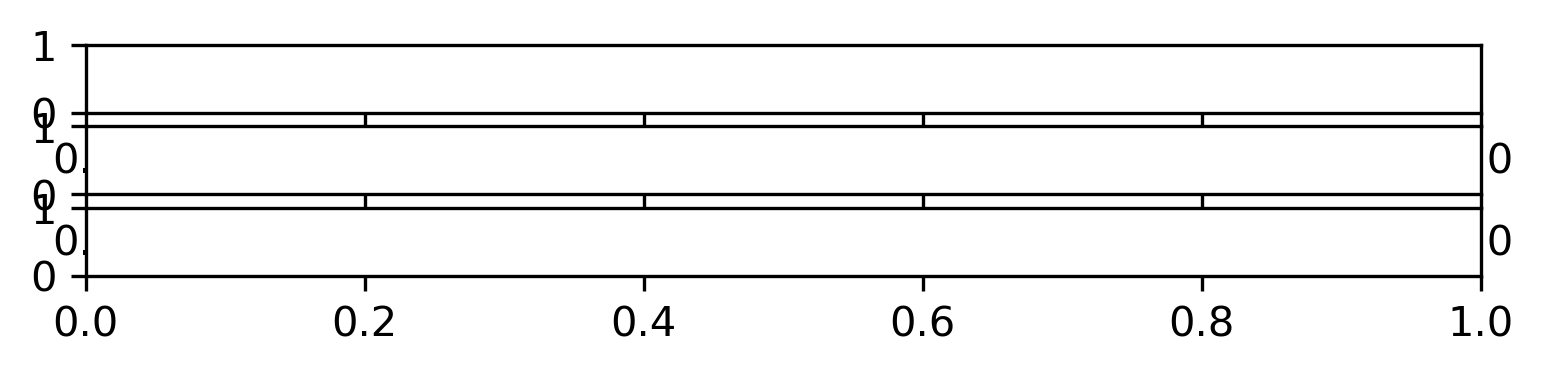

In [ ]:
morlet2(M, s, w=5)

In [ ]:
random_start

3563023

In [ ]:
import pywt
pywt.cwt(pyramidal_ripfilt, scales, 'cmor')

3563023


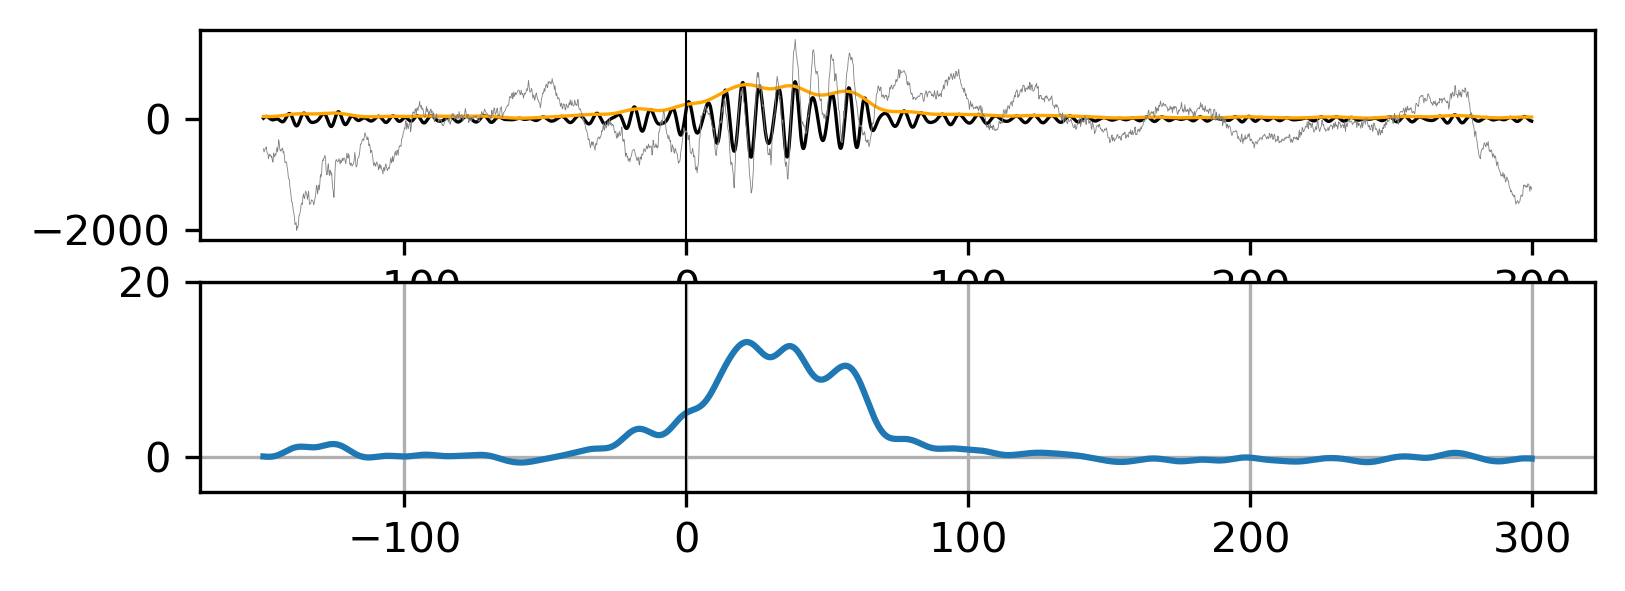

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(6,2),dpi=300)

display_window_ms = [-150,300]
display_windo_indx = np.arange(display_window_ms[0]*fs/1000,display_window_ms[1]*fs/1000)
window_time_ms = display_windo_indx/fs*1000
random_start = np.random.choice(good_starts)
print(random_start)

chosen_indicies = random_start+display_windo_indx
chosen_rip = pyramidal_ripfilt[  chosen_indicies.astype(int)  ]
ax[0].plot(window_time_ms,   pyramidal_ripfilt[  chosen_indicies.astype(int)  ]  ,color='k',linewidth=.8)
ax[0].plot(window_time_ms,   pyramidal_smoothed[  chosen_indicies.astype(int)  ]  ,color='orange',linewidth=.8)
ax[0].axvline(0,color='k',linewidth=.5)
ax[0].plot(window_time_ms,   pyramidal_downsampled[  chosen_indicies.astype(int)  ] ,color='gray',linewidth=.2)
ax[1].plot(window_time_ms,   pyramidal_ripp_z[  chosen_indicies.astype(int)  ]  )
ax[1].set_ylim([-4,20])
ax[1].axvline(0,color='k',linewidth=.5)
ax[1].grid('on')
plt.tight_layout
plt.show()




In [ ]:
delta_len =  - len(pyramidal_ripfilt)
delta_len/fs




In [ ]:

mat_data = sci.io.loadmat(os.path.join(zl_dir, 'ZL04_46_LFP_unsubtracted01_17_ripfilt.mat'))
ripple_trace_MATLAB = mat_data['ZL04_46_LFP_unsubtracted01_17_ripfilt'].flatten()

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(4,2),dpi=300)
show_wind = np.arange(1*fs).astype(int)

ending_mat = len(ripple_trace_MATLAB)-show_wind-1
ending_py = len(pyramidal_ripfilt)-show_wind-1

ax[0].plot(time_trace[show_wind], ripple_trace_MATLAB[show_wind],linewidth=.2)
ax0r = ax[0].twinx()
ax0r.plot(time_trace[show_wind], pyramidal_ripfilt[show_wind],linewidth=.2,color='r')
# ax[0].set_title('Ripple Filtered Python vs Matlab\nAlligned to START')

ax[1].plot(time_trace[ending_py], ripple_trace_MATLAB[ending_mat],linewidth=.2)
ax1r = ax[1].twinx()
ax1r.plot(time_trace[ending_py], pyramidal_ripfilt[ending_py],linewidth=.2,color='r')
# ax[1].set_title('Trace Ripple Filtered Python vs Matlab\nAlligned to END')

plt.tight_layout()
plt.show()
# ax[0].set_title('Matlab DownSampled')
# ax[0].set_title('Python DownSampled')

In [ ]:
def trace_scalebar(ax=[],origin=[],x_unit=[],y_unit=[],x_len=[],y_len=[],x_rescale=1,y_rescale=1,linewidth=1,baseline=0):

    xlims=ax.get_xlim()
    ylims=ax.get_ylim()

    x_len_scaled=x_len/x_rescale
    y_len_scaled=y_len/y_rescale

    # xbar
    ax.plot([origin[0],origin[0]+x_len_scaled],[origin[1],origin[1]],'k',linewidth=linewidth)
    # text
    ax.text(origin[0]+x_len_scaled/2,origin[1]-y_len_scaled*.1, f'{x_len}{x_unit}',ha='center',va='top')

    # ybar
    ax.plot([origin[0],origin[0]],[origin[1],origin[1]+y_len_scaled],'k',linewidth=linewidth)
    # text
    ax.text(origin[0]-x_len_scaled*.1,origin[1]+y_len_scaled/2, f'{y_len}{y_unit}',ha='right',va='center',rotation=90)

    # baseline
    ax.text(ax.get_xlim()[0],baseline,f'{baseline}{y_unit}',ha='right',va='center')
    ax.axis('off')
    return None
